RDD on CN data

# Data sources

From x.com we download the raw data (including notes-00000.tsv)

On HPC we apply the scoring algorithsms, generating output in parquet format

We preprocess and merge these files using

    preprocess_dates.py
    merge_ratings_with_notes.py

# Environment

see requirements.txt or communitynotes2025-05-09.yml

# Libraries

In [274]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle
import calendar
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf

# files and locations

userloc = '/home/tomstafford/Desktop/'
data_raw = userloc+'communitynotes/data2025raw/' # download from x.com
data_proc = userloc+'communitynotes/data2025proc/' # generating by CN code, run on HPC
data_post = userloc+'communitynotes/data2025post/' # post-processing, generated by our scripts

# TODO

add data prep instructions

## RDD
Our approach: check helpfulness scores of the first notes from each author in 2024. Check if they have written another note.

In [275]:
rated = pd.read_parquet(data_post+'rated_notes_compact.parquet', engine='auto')

len(rated) #1946619 for 2025 data

1946619

In [276]:
rated_2024 = rated[(rated.createdAt >= pd.Timestamp(2024, 1, 1)) &
                    (rated.createdAt < pd.Timestamp(2025, 1, 1))]

In [277]:
first_notes = rated_2024.groupby('noteAuthorParticipantId')\
    [['finalRatingStatus', 'numRatings', 'decidedBy','coreNoteIntercept', 'coreNoteInterceptMax']]\
    .first().reset_index()
have_another_note = rated_2024[rated_2024.groupby('noteAuthorParticipantId').cumcount() >= 2]\
    ['noteAuthorParticipantId'].to_list()
first_notes['if_written_again'] = first_notes['noteAuthorParticipantId'].isin(have_another_note)

In [278]:
# just focus on core model for now
first_notes = first_notes[first_notes['decidedBy'] == 'CoreModel (v1.1)']

<Axes: xlabel='if_written_again', ylabel='coreNoteInterceptMax'>

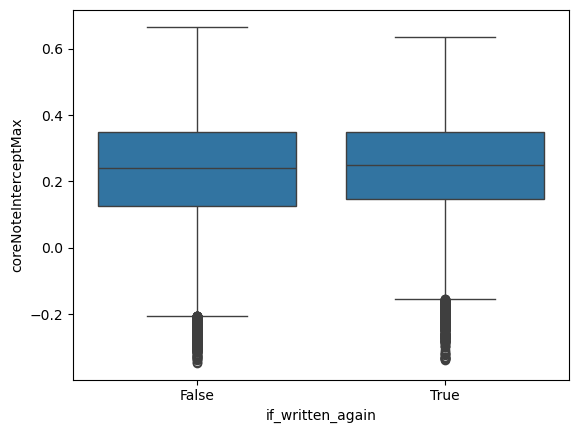

In [279]:
# boxplot of first notes' scores, divided by those followed (left) or not (right) by subsequent notes

sns.boxplot(y=first_notes['coreNoteInterceptMax'], x=first_notes['if_written_again'])

<Axes: >

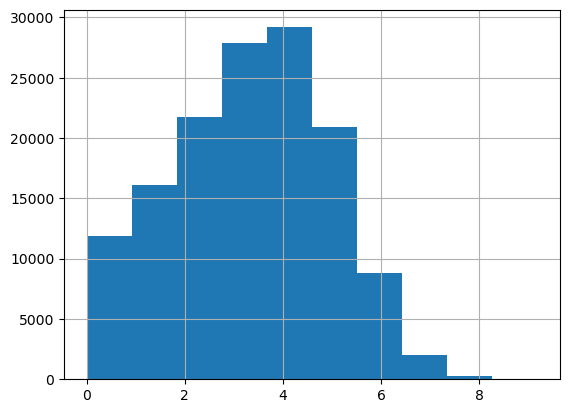

In [280]:
first_notes['log_numRatings']=np.log(first_notes['numRatings'])

first_notes['log_numRatings'].hist() #normal

<Axes: xlabel='if_written_again', ylabel='log_numRatings'>

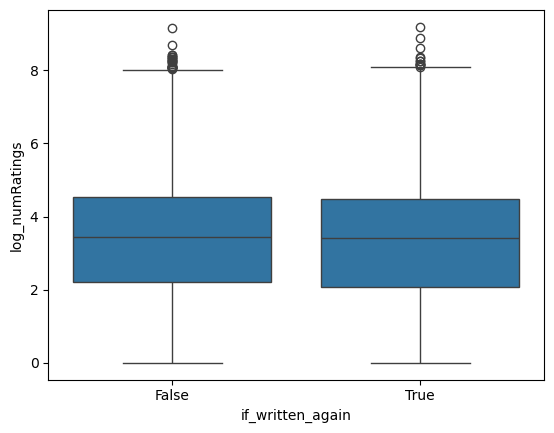

In [281]:
sns.boxplot(y=first_notes['log_numRatings'], x=first_notes['if_written_again'])

In [293]:
# RDD 

cutoff = 0.4 #threshold at which a note is rated as helpful
bandwidth = 0.05 #window around cutoff

# We fit a model allowing for different intercepts and slopes on either side of the cutoff.

# most recent score
#running_variable = first_notes['coreNoteIntercept'] # x value, continuous input

# highest score
running_variable = first_notes['coreNoteInterceptMax'] # x value, continuous input

# Treatment = 1 if running_variable >= cutoff, else 0
treatment = np.where(running_variable >= cutoff, 1, 0)

#
outcome_variable = first_notes['if_written_again'].astype(int) # y value, binary output

# we can restrict the analysis to a window (bandwidth) around the cutoff.

mask = (running_variable > cutoff - bandwidth)  & (running_variable < cutoff + bandwidth)

data = pd.DataFrame({
    'running_variable': running_variable[mask],
    'treatment': treatment[mask],
    'outcome_variable': outcome_variable[mask],
    'control' : first_notes[mask]['log_numRatings'],
    'numRatings' : first_notes[mask]['numRatings']
})

# Center the running variable at the cutoff for easier interpretation of the intercept
data['running_variable_centered'] = data['running_variable'] - cutoff

print("Sample Data Head:")
print(data.head())
print(f"\nNumber of treated units: {data['treatment'].sum()}")
print(f"Number of control units: {data['treatment'].count() - data['treatment'].sum()}")


Sample Data Head:
    running_variable  treatment  outcome_variable   control  numRatings  \
13          0.419939          1                 1  1.098612           3   
20          0.397091          0                 0  3.091042          22   
25          0.387633          0                 0  2.639057          14   
34          0.370153          0                 1  2.302585          10   
35          0.352753          0                 1  0.000000           1   

    running_variable_centered  
13                   0.019939  
20                  -0.002909  
25                  -0.012367  
34                  -0.029848  
35                  -0.047247  

Number of treated units: 7942
Number of control units: 12116


<Axes: xlabel='treatment', ylabel='control'>

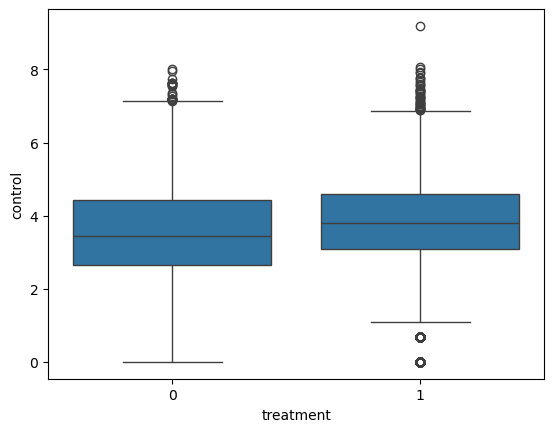

In [291]:
sns.boxplot(y=data['control'], x=data['treatment'])

In [ ]:
# report unique values for this column
first_notes['finalRatingStatus'].value_counts()

first_notes.groupby('finalRatingStatus').describe()

#divide into quintiles by numRatings
first_notes['Rgroup'] = pd.qcut(first_notes['numRatings'], 5, labels=False)

first_notes.groupby('Rgroup')['finalRatingStatus'].value_counts() #the vast majority, at all quintiles of numRatings are NEEDS MORE RATINGS

first_notes.groupby('Rgroup')['numRatings'].describe() #top 20% defined by having > 115 ratings



,count,mean,std,min,25%,50%,75%,max
Rgroup,,,,,,,,
0,28021.0,3.149531,1.701822,1.0,2.0,3.0,5.0,6.0
1,28199.0,12.101706,3.709418,7.0,9.0,12.0,15.0,19.0
2,27362.0,31.730977,8.032805,20.0,25.0,31.0,38.0,47.0
3,27787.0,75.951200,19.596133,48.0,59.0,73.0,92.0,116.0
4,27546.0,308.235207,310.562037,117.0,153.0,213.0,342.0,9806.0


In [312]:
data.groupby('treatment')['numRatings'].describe()

,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
0,12116.0,77.914906,143.249188,1.0,14.0,31.0,85.0,3042.0
1,7942.0,91.702846,193.850719,1.0,22.0,45.0,100.0,9806.0


In [286]:

# original
rdd_model_formula = 'outcome_variable ~ running_variable_centered * treatment'
#rdd_model_formula = 'outcome_variable ~ running_variable_centered * treatment + control'
rdd_model = smf.ols(formula=rdd_model_formula, data=data).fit()

print("\nRDD Model Summary (using all data):")
print(rdd_model.summary())


RDD Model Summary (using all data):
                            OLS Regression Results                            
Dep. Variable:       outcome_variable   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1561
Date:                Thu, 08 May 2025   Prob (F-statistic):              0.926
Time:                        12:25:29   Log-Likelihood:                -14558.
No. Observations:               20058   AIC:                         2.912e+04
Df Residuals:                   20054   BIC:                         2.915e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

In [287]:
# The coefficient for 'treatment' is the estimated effect at the cutoff.
estimated_effect = rdd_model.params['treatment']
print(f"\nEstimated Treatment Effect at the Cutoff: {estimated_effect:.4f}")

print("I think we can intepret this as a % change the chance of authoring again if published")

p_value_treatment = rdd_model.pvalues['treatment']
t_statistic_treatment = rdd_model.tvalues['treatment']
conf_int_treatment = rdd_model.conf_int().loc['treatment']

# print out p value and t-statistic for treatment
print(f"\nP-value for treatment: {p_value_treatment:.4f}")
print(f"T-statistic for treatment: {t_statistic_treatment:.4f}")
print(f"Confidence interval for treatment: " + str(conf_int_treatment))




Estimated Treatment Effect at the Cutoff: -0.0001
I think we can intepret this as a % change the chance of authoring again if published

P-value for treatment: 0.9936
T-statistic for treatment: -0.0080
Confidence interval for treatment: 0   -0.028076
1    0.027847
Name: treatment, dtype: float64


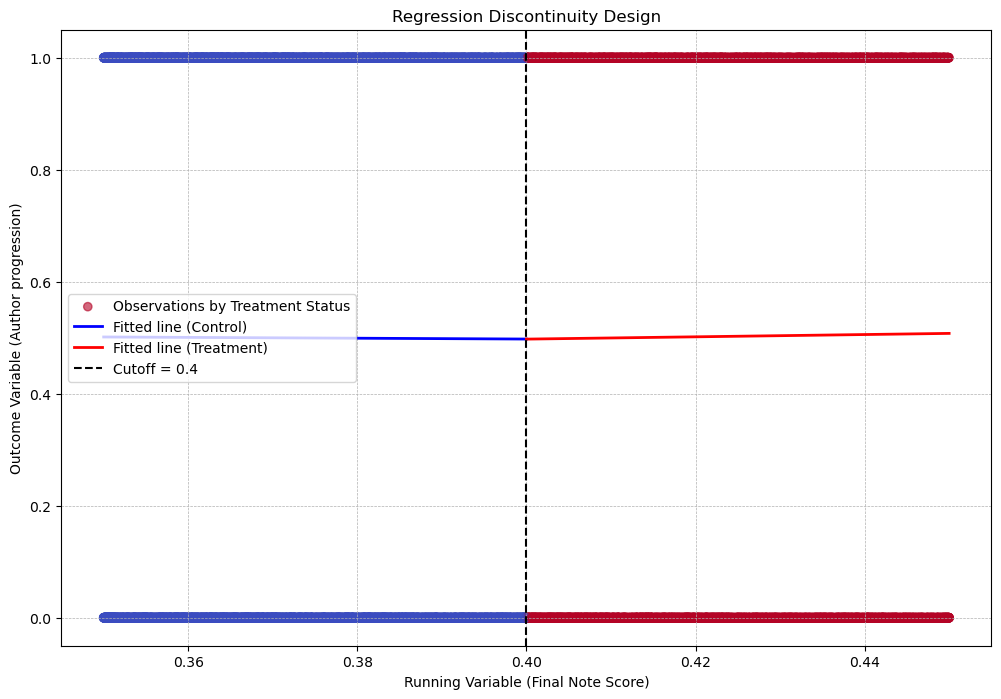

In [288]:
# 3. Visualization
plt.figure(figsize=(12, 8))
plt.scatter(data['running_variable'], data['outcome_variable'],
            c=data['treatment'], cmap='coolwarm', alpha=0.6, label='Observations by Treatment Status')

# Plot regression lines for each side of the cutoff
# For values below the cutoff (treatment=0)
x_below = np.linspace(data['running_variable'].min(), cutoff, 100)
y_below = rdd_model.params['Intercept'] + rdd_model.params['running_variable_centered'] * (x_below - cutoff)

# For values above the cutoff (treatment=1)
x_above = np.linspace(cutoff, data['running_variable'].max(), 100)
y_above = (rdd_model.params['Intercept'] + rdd_model.params['treatment']) + \
          (rdd_model.params['running_variable_centered'] + rdd_model.params['running_variable_centered:treatment']) * (x_above - cutoff)

plt.plot(x_below, y_below, color='blue', linestyle='-', linewidth=2, label='Fitted line (Control)')
plt.plot(x_above, y_above, color='red', linestyle='-', linewidth=2, label='Fitted line (Treatment)')

plt.axvline(x=cutoff, color='black', linestyle='--', label=f'Cutoff = {cutoff}')
plt.xlabel('Running Variable (Final Note Score)')
plt.ylabel('Outcome Variable (Author progression)')
plt.title('Regression Discontinuity Design')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('plots/RDD.png',bbox_inches='tight',dpi=120)
plt.show()

